In [75]:
from dicke_h import *
from qutip import *
from matplotlib import pyplot as plt
from pim_brute import collective_algebra, su2_algebra, excited_state_brute, make_cops

In [91]:
# system size
ntls = 6
N = ntls

# spin dynamics hamiltonian coefficients
w0 = 1
wi = 2
w_int_phot = 1 

# spin dynamics lindblad coefficients
gE = 0.5
gD = 0.3
gP = 0.9

gCE = 1
gCD = 1.0
gCP = 0.4

# define time steps
t = np.linspace(0, 3, 100)

In [92]:
## Dicke basis
# define algebra (Dicke basis)
[jx, jy, jz, jp, jm] = j_algebra(N)
# build spin dynamics (Dicke basis)
h0 = w0 * jz
hint = wi * jx
h = h0 + hint
dicke = Dicke(hamiltonian = h, N = N, loss = gE, pumping = gP, dephasing = gD, emission = gCE, collective_pumping = gCP, collective_dephasing = gCD)
psolv = Pisolve(dicke)
#build spin liouvillian (Dicke basis)
liouv = psolv.liouvillian()
#set initial state for spins (Dicke basis)
rho0 = dicke.dicke(N/2, N/2)
#solve using qutip (Dicke basis)
result = mesolve(liouv, rho0, t, [], e_ops = [jz, jp*jm])
rhot = result.states
jz_t = result.expect[0]
jpjm_t = result.expect[1]

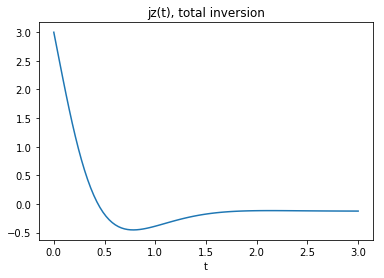

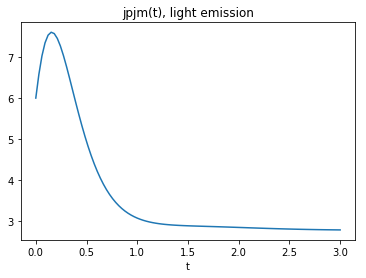

In [93]:
## Dicke basis plots
fig1 = plt.figure()
plt.plot(t, jz_t)
#plt.ylim([-1,1])
plt.title('jz(t), total inversion')
plt.xlabel('t')
plt.show()
plt.close()

fig2 = plt.figure()
plt.plot(t, jpjm_t)
#plt.ylim([-1,1])
plt.title('jpjm(t), light emission')
plt.xlabel('t')
plt.show()
plt.close()

In [94]:
## TLS spin basis
Nn = N
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = sigmam()
sp = sigmap()
[Jx, Jy, Jz, Jm, Jp] = collective_algebra(Nn)
[sx_tls, sy_tls, sz_tls, sm_tls, sp_tls] = su2_algebra(Nn)
h0_tls = w0 * Jz
hint_tls = wi * Jx
h_tls = h0_tls + hint_tls
rho0_tls = ket2dm(excited_state_brute(N))
c_ops_tls = [np.sqrt(gCE)*Jm]
e_ops_tls = [Jz, Jp * Jm]
liouv_tls = liouvillian(h_tls, c_ops_tls)

In [95]:
c_ops_tls = make_cops(N = ntls, emission = gCE, loss = gE, dephasing = gD, pumping = gP, collective_pumping = gCP, collective_dephasing = gCD)
#result_tls = mesolve(h_tls, rho0_tls, t, c_ops_tls, e_ops_tls)
liouv_tls = liouvillian(h_tls, c_ops_tls)
result_tls = mesolve(liouv_tls, rho0_tls, t, [], e_ops_tls)

In [96]:
rhot_tls = result_tls.states
jz_t_tls = result_tls.expect[0]
jpjm_t_tls = result_tls.expect[1]

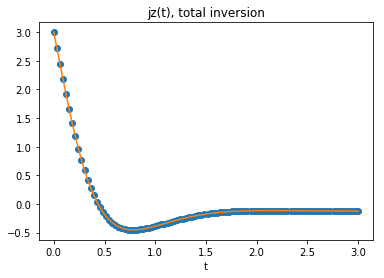

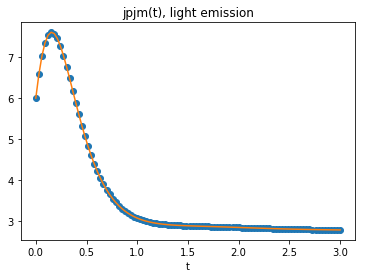

In [97]:
## TLS basis vs. Dicke basis comparison plots
fig5 = plt.figure()
plt.plot(t, jz_t, 'o', t, jz_t_tls )
#plt.ylim([-1,1])
plt.title('jz(t), total inversion')
plt.xlabel('t')
plt.show()
plt.close()

fig6 = plt.figure()
plt.plot(t, jpjm_t, 'o', t, jpjm_t_tls )
#plt.ylim([-1,1])
plt.title('jpjm(t), light emission')
plt.xlabel('t')
plt.show()
plt.close()

In [98]:
#build photonic liouvillian
nphot = 2
wc = 0.1
kappa = 0.1
a = destroy(nphot)
h_phot = wc * a.dag() * a
c_ops_phot = [np.sqrt(kappa) * a]
liouv_phot = liouvillian(h_phot, c_ops_phot)
nds = num_dicke_states(ntls)

In [99]:
# Dicke basis tensor Liouvillian
liouv_tot = super_tensor(liouv_phot, to_super(qeye(nds))) + super_tensor(to_super(qeye(nphot)), liouv)
#strong coupling light-matter interaction
h_int_phot = w_int_phot * tensor(a + a.dag(), jx) 
liouv_hint = - 1j* spre(h_int_phot) + 1j * spost(h_int_phot)
liouv_tot_int = liouv_hint + liouv_tot

In [100]:
#solve using qutip (Dicke basis)
options = Options()#nsteps = 10000, atol = 1e-6)
jz_tot = tensor(qeye(nphot), jz)
jpjm_tot = tensor(qeye(nphot), jp*jm)
adag_a_tot = tensor(a*a.dag(), qeye(nds))
rho0_phot = ket2dm(basis(nphot))
rho0_tot = tensor(rho0_phot, rho0)

result_tot = mesolve(liouv_tot_int, rho0_tot, t, [], e_ops = [jz_tot, jpjm_tot, adag_a_tot], options=options)
rhot_tot = result_tot.states
jzt_tot = result_tot.expect[0]
jpjmt_tot = result_tot.expect[1]
adagat_tot = result_tot.expect[2]

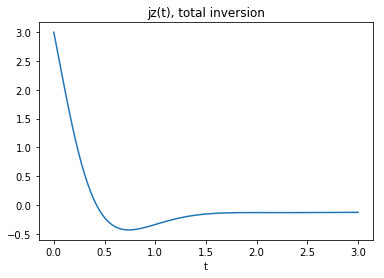

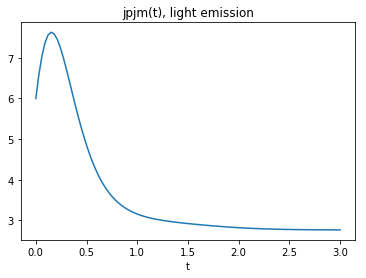

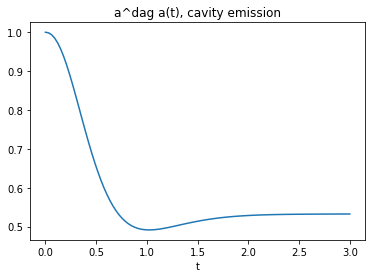

In [101]:
fig7 = plt.figure()
plt.plot(t, jzt_tot)
#plt.ylim([-1,1])
plt.title('jz(t), total inversion')
plt.xlabel('t')
plt.show()
plt.close()

fig8 = plt.figure()
plt.plot(t, jpjmt_tot)
#plt.ylim([-1,1])
plt.title('jpjm(t), light emission')
plt.xlabel('t')
plt.show()
plt.close()

fig9 = plt.figure()
plt.plot(t, adagat_tot)
#plt.ylim([-1,1])
plt.title('a^dag a(t), cavity emission')
plt.xlabel('t')
plt.show()
plt.close()

In [102]:
# TLS basis tensor Liouvillian
#sm_sup = Qobj(spre(sm).full(),dims = spre(sm).dims, type = "super")
#sm_sup
# correct N TLS objects dimensions using tensor product structure of Hilbert space
dims_ntls = []
id_ntls = []
for i in range(0, ntls):
    dims_ntls.append(2)
    id_ntls.append(qeye(2))
id_ntls = tensor(id_ntls)
dims_ntls = [dims_ntls, dims_ntls]

liouv_tot_tls = super_tensor(liouv_phot, to_super(id_ntls)) + super_tensor(to_super(qeye(nphot)), liouv_tls)
#strong coupling light-matter interaction
h_int_phot_tls = w_int_phot * tensor(a + a.dag(), Jx) 
liouv_hint_tls = - 1j* spre(h_int_phot_tls) + 1j * spost(h_int_phot_tls)
liouv_tot_int_tls = liouv_hint_tls + liouv_tot_tls

In [103]:
#solve using qutip (TLS basis)
options = Options()#nsteps = 10000, atol = 1e-6)
jz_tot_tls = tensor(qeye(nphot), Jz)
jpjm_tot_tls = tensor(qeye(nphot), Jp*Jm)
adag_a_tot_tls = tensor(a*a.dag(), id_tls)
rho0_phot = ket2dm(basis(nphot))
rho0_tot = tensor(rho0_phot, rho0_tls)

result_tot_tls = mesolve(liouv_tot_int_tls, rho0_tot, t, [], e_ops = [jz_tot_tls, jpjm_tot_tls, adag_a_tot_tls], options=options)
rhot_tot_tls = result_tot_tls.states
jzt_tot_tls = result_tot_tls.expect[0]
jpjmt_tot_tls = result_tot_tls.expect[1]
adagat_tot_tls = result_tot_tls.expect[2]

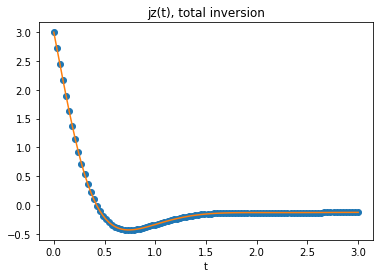

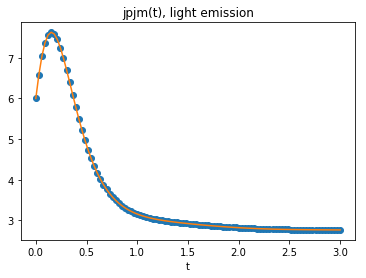

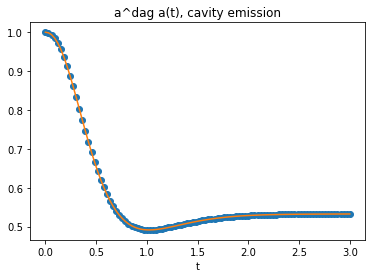

In [105]:
fig10 = plt.figure()
plt.plot(t, jzt_tot, 'o',t, jzt_tot_tls )
#plt.ylim([-1,1])
plt.title('jz(t), total inversion')
plt.xlabel('t')
plt.show()
plt.close()

fig11 = plt.figure()
plt.plot(t, jpjmt_tot, 'o',t, jpjmt_tot_tls)
#plt.ylim([-1,1])
plt.title('jpjm(t), light emission')
plt.xlabel('t')
plt.show()
plt.close()

fig12 = plt.figure()
plt.plot(t, adagat_tot, 'o', t, adagat_tot_tls)
#plt.ylim([-1,1])
plt.title('a^dag a(t), cavity emission')
plt.xlabel('t')
plt.show()
plt.close()